In [1]:
# Package importing
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


#Data Retrieval
import os

In [2]:
# DANECHKA я ебал этот куда, просто комментируй этот блок
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Включаем оптимизации oneDNN (важно для Intel)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

# Для 12-го поколения особенно важно включить Intel DL Boost
os.environ['TF_ENABLE_MKL_NATIVE_FORMAT'] = '1'

def configure_cpu_optimization():
    physical_cores = os.cpu_count() // 2
    logical_cores = os.cpu_count()
    
    tf.config.threading.set_intra_op_parallelism_threads(logical_cores)
    tf.config.threading.set_inter_op_parallelism_threads(physical_cores)
    
    tf.config.optimizer.set_jit(True)
    tf.config.set_soft_device_placement(True)

    # itex.set_backend('cpu', throughput_mode=True)

configure_cpu_optimization()

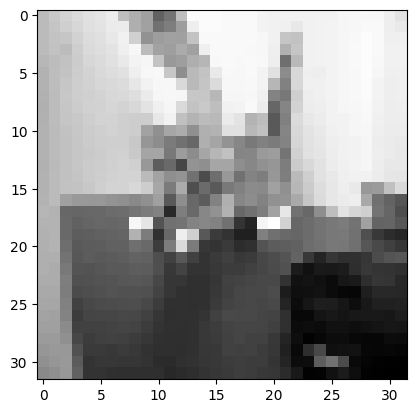

In [3]:
# Data loading and pipeline preparing
path = os.path.join("./ieee-ai-and-ml-demystified/train/train","")
path_test = os.path.join("./ieee-ai-and-ml-demystified/test1/test1","")

for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(32, 32))
    plt.imshow(new_img_array,cmap="gray")
    break
    
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))
        X.append(new_img_array)
        y.append(category)


create_test_data(path)

X = np.array(X).reshape(-1, 32,32,1)
y = np.array(y)

X = X/255.0

In [4]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

# Создание оптимизированных tf.data.Dataset
def create_dataset(images, labels, is_training=False, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Добавляем аугментацию для обучающего набора
    if is_training:
        # Определяем функцию аугментации
        def augment(image, label):
            # Случайный поворот
            image = tf.image.random_flip_left_right(image)
            # Случайное изменение яркости
            image = tf.image.random_brightness(image, 0.2)
            # Случайное изменение контраста
            image = tf.image.random_contrast(image, 0.8, 1.2)
            return image, label
            
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=1000)
    
    # Батчинг и предварительная загрузка
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = create_dataset(X_train, y_train, is_training=True)
val_dataset = create_dataset(X_val, y_val)

Размер обучающей выборки: (20000, 32, 32, 1)
Размер валидационной выборки: (5000, 32, 32, 1)


Сводка модели:


d:\Home\Documents\GitHub\ai-coop-project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 665,953 (2.54 MB)

 Trainable params: 664,801 (2.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

Начало обучения модели...
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5426 - loss: 5.1382
Epoch 1: val_accuracy improved from -inf to 0.50320, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.5427 - loss: 5.1372 - val_accuracy: 0.5032 - val_loss: 4.1878 - learning_rate: 1.0000e-04
Epoch 2/50
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5923 - loss: 4.0539
Epoch 2: val_accuracy improved from 0.50320 to 0.62940, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.5923 - loss: 4.0527 - val_accuracy: 0.6294 - val_loss: 3.4025 - learning_rate: 1.0000e-04
Epoch 3/50
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6106 - loss: 3.3500
Epoch 3: val_accuracy did not improve from 0.62940
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.6106 - loss: 3.3491 - val_accuracy: 0.5922 - val_loss: 2.9092 - learning_rate: 1.0000e-04
Epoch 4/50
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77m

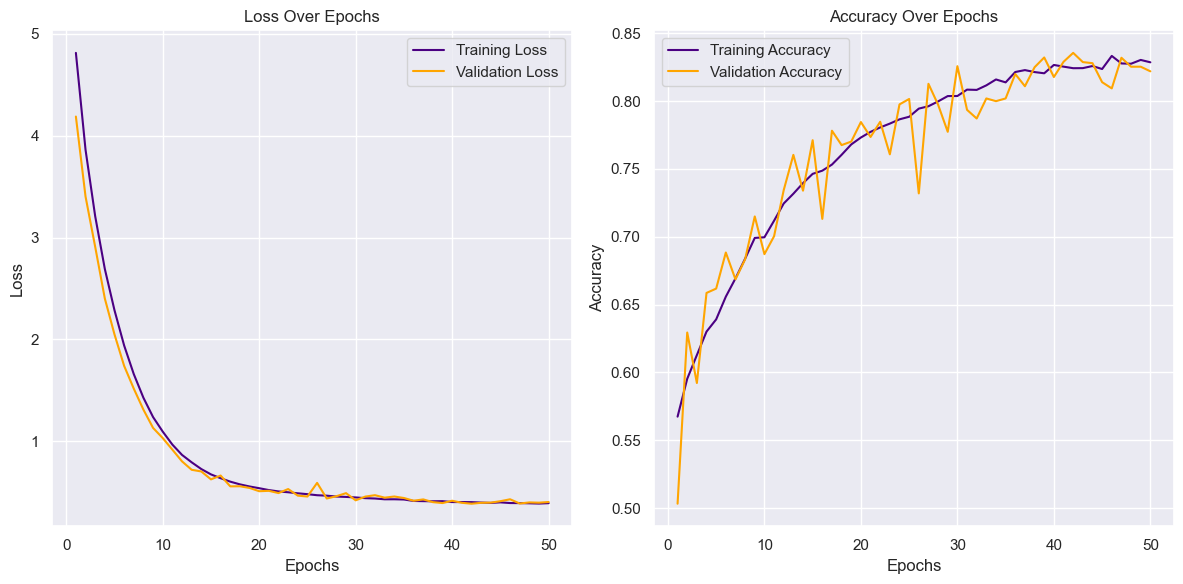

In [5]:
model = Sequential([
    # Первый блок сверточных слоев
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Второй блок сверточных слоев
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Третий блок сверточных слоев
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Полносвязные слои
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компиляция с оптимизированным оптимизатором
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Сводка модели:")
model.summary()

# Настройка callbacks для более эффективного обучения
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

# Вот эта штука позволяет сдлеать откат
# если LOSS слишком большой
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001
)

callbacks = [checkpoint, early_stopping, reduce_lr]

print("Начало обучения модели...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

model.save('cat_dog_classifier_final.keras')
print("Модель сохранена в файл: cat_dog_classifier_final.h5")

# Визуализация процесса обучения
sns.set_theme(style="darkgrid", palette="bright")
# График функции потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss', color='indigo')
sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy', color='indigo')
sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


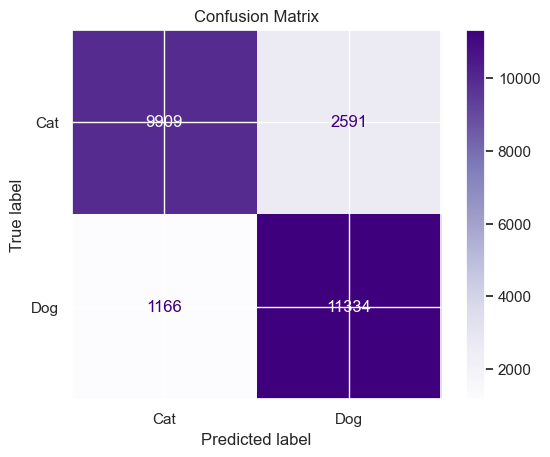

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


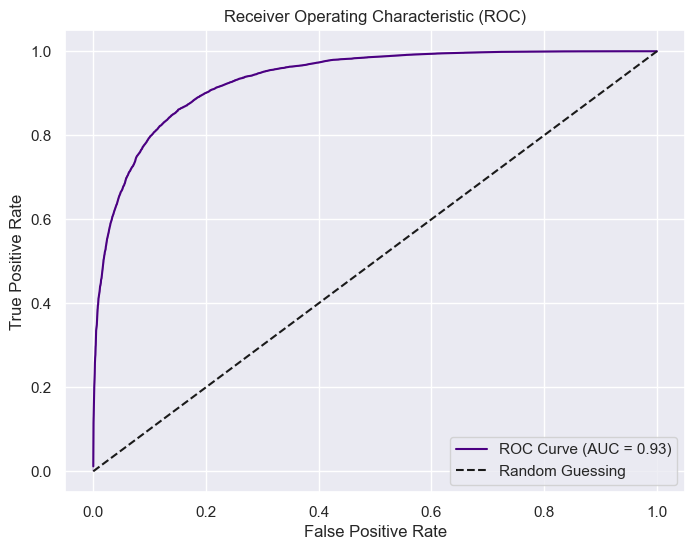

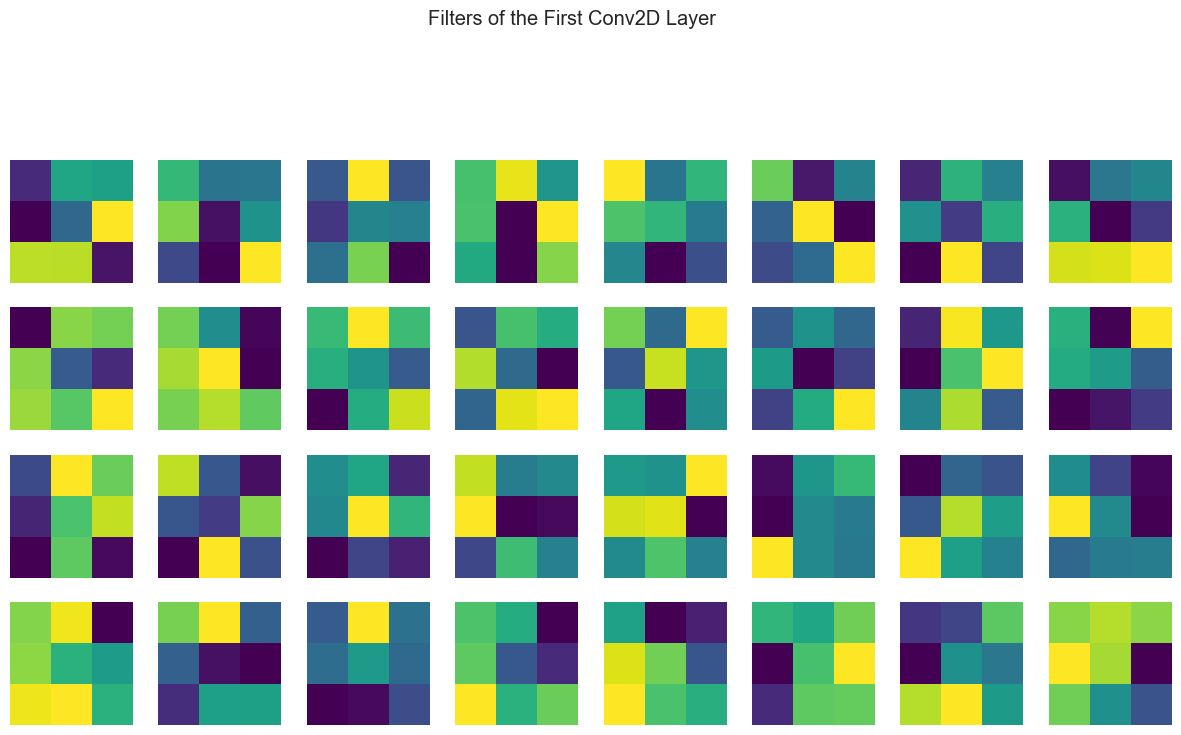

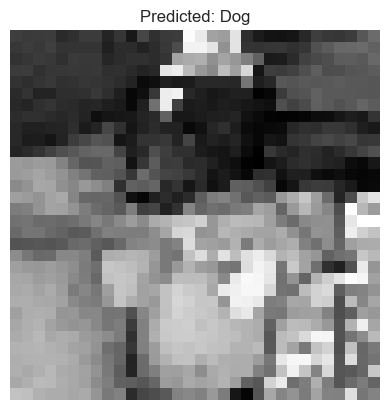

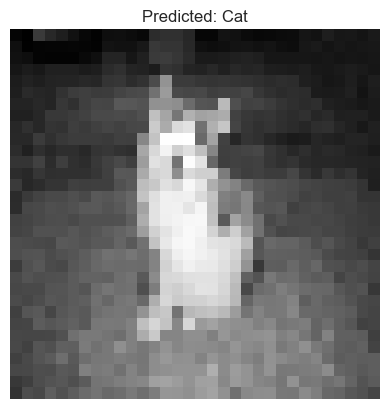

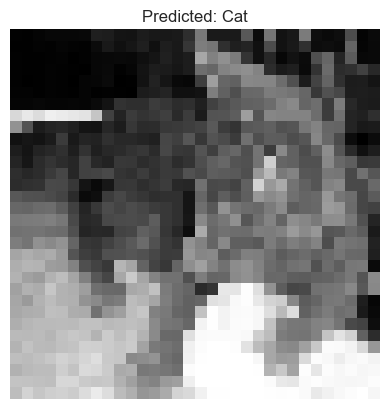

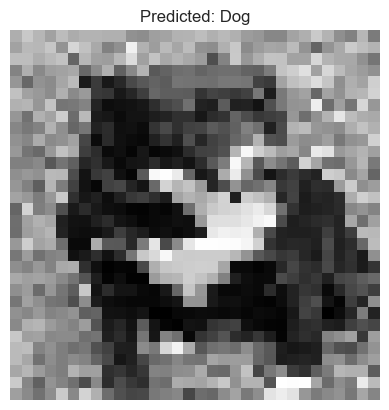

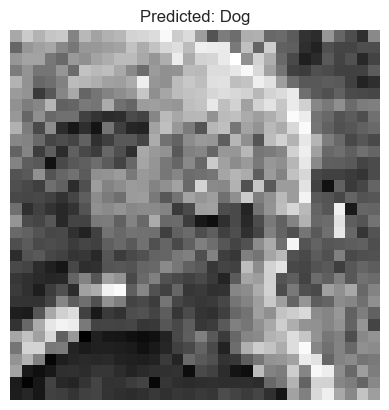

              precision    recall  f1-score   support

         Cat       0.89      0.79      0.84     12500
         Dog       0.81      0.91      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



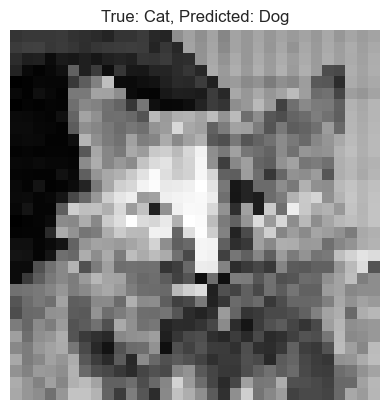

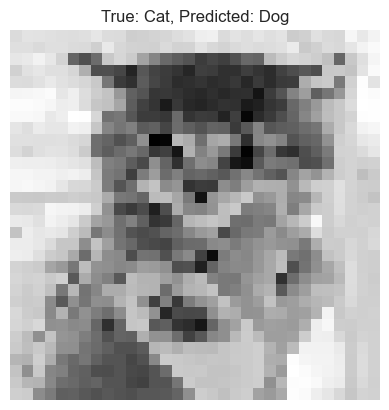

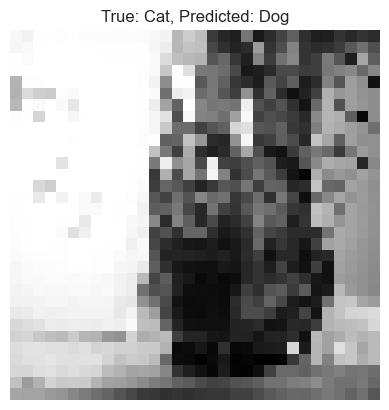

In [6]:
# чтоб не ебаться
model_path = 'cat_dog_classifier_final.keras'
model = load_model(model_path)

X_test = []
id_line = []
def create_test1_data(path1):
    for p in os.listdir(path1):
        id_line.append(p.split(".")[0])
        img_array = cv2.imread(os.path.join(path1,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))
        X_test.append(new_img_array)
        
create_test1_data(path_test)
X_test = np.array(X_test).reshape(-1,32,32,1)
X_test = X_test/255


predictions = model.predict(X_test)

predicted_val = [int(round(p[0])) for p in predictions] 

predicted_val[0:5]


submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val}) 

submission_df.to_csv("submission123.csv", index=False)

# Пример: если у вас есть тестовые данные и предсказания
y_true = y  # Истинные метки (например, обучающие данные)
y_pred = (model.predict(X) > 0.5).astype("int32")  # Предсказания модели

# Построение матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap='Purples')
plt.title('Confusion Matrix')
plt.show()

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y, model.predict(X))
roc_auc = auc(fpr, tpr)

# Построение графика ROC-кривой для оценки качества бинарной классификации
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='indigo')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Визуализация фильтров первого сверточного слоя
filters, biases = model.layers[0].get_weights()
n_filters = filters.shape[-1]

plt.figure(figsize=(15, 15))
for i in range(n_filters):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters[:, :, 0, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Filters of the First Conv2D Layer')
plt.show()

# Визуализация предсказаний модели на тестовых данных
for i in range(5):
    plt.imshow(X_test[i].reshape(32, 32), cmap='gray')
    plt.title(f'Predicted: {"Dog" if predicted_val[i] == 1 else "Cat"}')
    plt.axis('off')
    plt.show()

# Расчёт точности для каждого класса (cat и dog)
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# Примеры изображений на которых модель ошиблась
errors = np.where(y_true != y_pred.flatten())[0]

# Визуализация ошибок
for i in errors[:3]:  # Покажем первые 5 ошибок
    plt.imshow(X[i].reshape(32, 32), cmap='gray')
    plt.title(f'True: {"Dog" if y_true[i] == 1 else "Cat"}, Predicted: {"Dog" if y_pred[i] == 1 else "Cat"}')
    plt.axis('off')
    plt.show()
  

In [ ]:
def predict_image(image_path):
    # Загрузка изображения
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Ошибка загрузки изображения"
    
    # Предобработка
    resized_img = cv2.resize(img, (32, 32))
    normalized_img = resized_img / 255.0
    img_array = np.expand_dims(normalized_img, axis=[0, -1])
    
    # Предсказание
    prediction = model.predict(img_array)[0][0]
    result = "Собака" if prediction > 0.5 else "Кошка"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return f"Результат: {result} (уверенность: {confidence*100:.2f}%)"

# Создание Flask-приложения для интерфейса
from flask import Flask, request, render_template, jsonify
import io
from PIL import Image

app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'Файл не найден'})
    
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'Файл не выбран'})
    
    # Чтение и обработка изображения
    in_memory_file = io.BytesIO()
    file.save(in_memory_file)
    image = np.array(Image.open(in_memory_file))
    
    # Преобразуем в оттенки серого если нужно
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    # Изменяем размер до 32x32
    resized = cv2.resize(gray, (32, 32))
    # Нормализуем значения пикселей
    normalized = resized / 255.0
    # Преобразуем форму для модели
    processed_image = np.expand_dims(normalized, axis=[0, -1])
    
    # Получение предсказания
    prediction = model.predict(processed_image)[0][0]
    result = "Собака" if prediction > 0.5 else "Кошка"
    confidence = float(prediction) if prediction > 0.5 else float(1 - prediction)
    
    return jsonify({
        'result': result,
        'confidence': f"{confidence * 100:.2f}%"
    })

print("Чтобы запустить веб-интерфейс, выполните: app.run(debug=True)")

# Создаем HTML шаблон для веб-интерфейса
with open('./index.html', 'w') as f:
    f.write("""
<!DOCTYPE html>
<html>
<head>
    <title>Классификатор кошек и собак</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
        }
        .upload-form {
            border: 2px dashed #ccc;
            padding: 20px;
            text-align: center;
            margin-bottom: 20px;
        }
        #preview {
            max-width: 300px;
            margin: 20px auto;
        }
        .result {
            padding: 10px;
            border-radius: 5px;
            margin-top: 10px;
            text-align: center;
            font-weight: bold;
            font-size: 18px;
        }
    </style>
</head>
<body>
    <h1>Классификатор кошек и собак</h1>
    <div class="upload-form">
        <h2>Загрузите изображение</h2>
        <input type="file" id="imageInput" accept="image/*">
        <div id="preview"></div>
        <button id="predictBtn" disabled>Определить</button>
    </div>
    <div id="result" class="result"></div>

    <script>
        const imageInput = document.getElementById('imageInput');
        const previewDiv = document.getElementById('preview');
        const predictBtn = document.getElementById('predictBtn');
        const resultDiv = document.getElementById('result');

        imageInput.addEventListener('change', function() {
            const file = this.files[0];
            if (file) {
                const reader = new FileReader();
                reader.onload = function(e) {
                    previewDiv.innerHTML = `<img src="${e.target.result}" style="max-width: 100%;">`;
                    predictBtn.disabled = false;
                }
                reader.readAsDataURL(file);
            }
        });

        predictBtn.addEventListener('click', function() {
            const file = imageInput.files[0];
            if (!file) return;

            const formData = new FormData();
            formData.append('file', file);

            resultDiv.innerHTML = 'Обработка...';
            
            fetch('/predict', {
                method: 'POST',
                body: formData
            })
            .then(response => response.json())
            .then(data => {
                if (data.error) {
                    resultDiv.innerHTML = `Ошибка: ${data.error}`;
                } else {
                    resultDiv.innerHTML = `Результат: ${data.result} (уверенность: ${data.confidence})`;
                }
            })
            .catch(error => {
                resultDiv.innerHTML = `Ошибка: ${error.message}`;
            });
        });
    </script>
</body>
</html>
    """)

Чтобы запустить веб-интерфейс, выполните: app.run(debug=True)


FileNotFoundError: [Errno 2] No such file or directory: 'templates/index.html'